# Visualisation and validation of the NESO forecasts

In [1]:
# Load data

import os

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

data_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")

# Load BMRS (actual) data
df_bmrs = pd.read_csv(
    os.path.join(data_dir, "bmrs_data.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

# Sort by date and period
df_bmrs = df_bmrs.sort_values(["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"])

print("BMRS dataset:\n")
print(df_bmrs.info())

# Load NESO (forecast) data
df_neso = pd.read_csv(
    os.path.join(data_dir, "neso_forecasts.csv"),
    parse_dates=["TARGET_DATE", "ISSUE_DATE"],
)

# Sort by date and period
df_neso = df_neso.sort_values(["TARGET_DATE", "ISSUE_PERIOD"])

print("NESO dataset:\n")
print(df_neso.info())

BMRS dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68208 entries, 0 to 68207
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SETTLEMENT_DATE    68208 non-null  datetime64[ns]
 1   SETTLEMENT_PERIOD  68208 non-null  int64         
 2   BIOMASS            68208 non-null  float64       
 3   GAS                68208 non-null  float64       
 4   COAL               68208 non-null  float64       
 5   OIL                68208 non-null  float64       
 6   NUCLEAR            68208 non-null  float64       
 7   SOLAR              68208 non-null  float64       
 8   WIND               68208 non-null  float64       
 9   OTHER              68208 non-null  float64       
 10  INTER              68208 non-null  float64       
 11  INDO               68208 non-null  float64       
 12  ITSO               68208 non-null  float64       
 13  ELECTRICITY_PRICE  68208 non-null  float64    

Plot demand snapshot:

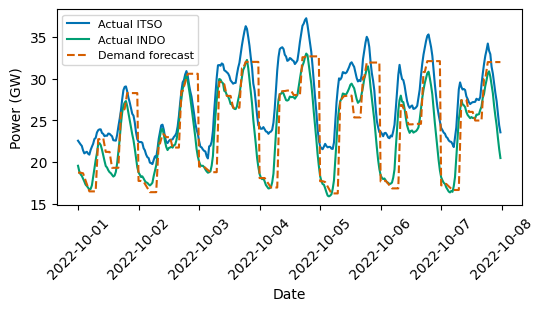

In [2]:
# Reset index to access TARGET_DATE and TARGET_PERIOD as columns
df_actual = df_bmrs
df_pred = df_neso

# Get time snapshot
start_date = pd.Timestamp("2022-10-01")
end_date = pd.Timestamp("2022-10-07")

mask_actual = (
    (df_actual["SETTLEMENT_DATE"] >= start_date) 
    & 
    (df_actual["SETTLEMENT_DATE"] <= end_date)
)

mask_pred = (
    (df_pred["TARGET_DATE"] >= start_date) 
    & 
    (df_pred["TARGET_DATE"] <= end_date)
)

df_actual_snap = df_actual[mask_actual].copy()
df_pred_snap = df_pred[mask_pred].copy()

# Create datetime from settlement date and period
# Note: Settlement periods are 1-48 for half-hourly intervals
df_actual_snap["datetime"] = df_actual_snap[
    "SETTLEMENT_DATE"
] + pd.to_timedelta((df_actual_snap["SETTLEMENT_PERIOD"] - 1) * 30, unit="m")

df_pred_snap["datetime"] = df_pred_snap[
    "TARGET_DATE"
] + pd.to_timedelta((df_pred_snap["TARGET_PERIOD"] - 1) * 30, unit="m")

# Plot
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")

ax.plot(
    df_actual_snap["datetime"],
    df_actual_snap["ITSO"] / 1000,
    label="Actual ITSO",
)

ax.plot(
    df_actual_snap["datetime"],
    df_actual_snap["INDO"] / 1000,
    label="Actual INDO",
)

ax.plot(
    df_pred_snap["datetime"],
    df_pred_snap["DEMAND_FORECAST"] / 1000,
    label="Demand forecast",
    ls='--'
)

ax.legend(fontsize=8)
plt.xticks(rotation=45)
ax.set_ylabel("Power (GW)", fontsize=10)
ax.set_xlabel("Date", fontsize=10)
plt.show()

Plot generation snapshot:

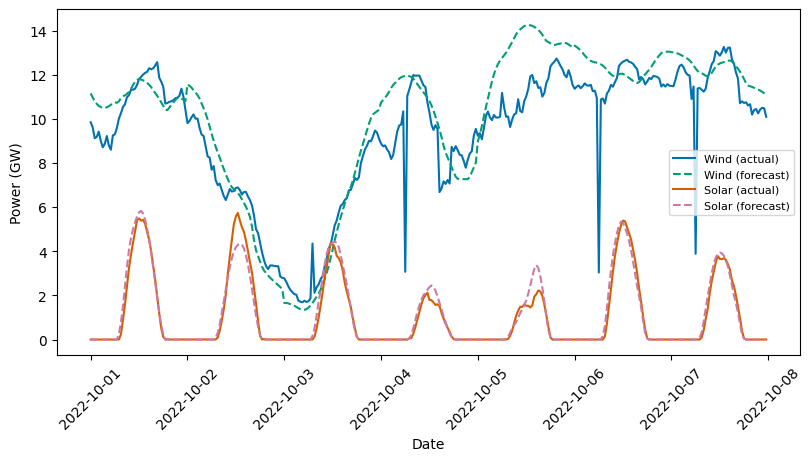

In [3]:
wind_total_forecast = (
    df_pred_snap["WIND_FORECAST"]
    + df_pred_snap["EMBEDDED_WIND_FORECAST"]
)
wind_metered_forecast = df_pred_snap["WIND_FORECAST"]
solar_forecast = df_pred_snap["EMBEDDED_SOLAR_FORECAST"]

fig, ax = plt.subplots(figsize=(16 / 2, 9 / 2), layout="constrained")

# Wind plots
ax.plot(
    df_actual_snap["datetime"], df_actual_snap["WIND"] / 1000,
    label="Wind (actual)",
)
ax.plot(
    df_pred_snap["datetime"], wind_metered_forecast / 1000,
    ls="--", label="Wind (forecast)",
)

# Solar plots
ax.plot(
    df_actual_snap["datetime"], df_actual_snap["SOLAR"] / 1000,
    label="Solar (actual)",

)
ax.plot(
    df_pred_snap["datetime"], solar_forecast / 1000,
    ls="--", label="Solar (forecast)",
)
ax.legend(fontsize=8)
plt.xticks(rotation=45)
ax.set_ylabel("Power (GW)", fontsize=10)
ax.set_xlabel("Date", fontsize=10)
plt.show()